In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle


#---------------------
# Load and clean data
#---------------------

data = pd.read_csv("customer_churn_dataset.csv")
data = data.dropna() # you could use imputation here instead of dropping 

#------------------------
# check for missing values
#------------------------
print("Missing values after dropping NaNs:")
print(data.isnull().sum())

#------------------------
# explore the data Analysis (EDA)
#------------------------

print(data.shape)

print(data.head)

print(data.describe)

print(data.info)

print(data.columns)

#----------------------------------------------------
# checking the class distribution of the target column
#----------------------------------------------------

print("Class distribution in 'churn' column:")
print(data['churn'].value_counts())



Missing values after dropping NaNs:
customer_id         0
tenure              0
monthly_charges     0
total_charge        0
contract            0
payment_method      0
internet_service    0
tech_support        0
online_security     0
support_calls       0
churn               0
dtype: int64
(17987, 11)
<bound method NDFrame.head of        customer_id  tenure  monthly_charges  total_charge        contract  \
0                1      52            54.20       2818.40  Month-to-month   
1                2      15            35.28        529.20  Month-to-month   
2                3      72            78.24       5633.28  Month-to-month   
3                4      61            80.24       4894.64        One year   
4                5      21            39.38        826.98  Month-to-month   
...            ...     ...              ...           ...             ...   
19995        19996      36            69.51       2502.36        Two year   
19996        19997      10            59.88        

# insights:

#------------------------
# 1. customerID: Unique identifier for each customer. 
# 2. NO missing values in this dataset.
# 3. The dataset contains 7043 rows and 21 columns.
# 4. The target variable 'churn' is imbalanced, with more 'No
#    than 'Yes' instances.
# 5. class imbalance identified in the target

In [70]:
# Numerical Features - Analysis
# Understand the distribution of teh numerical features.

def plot_histogram(data,column_name):
    
    plt.figure(figsize=(5,3))
    sns.histplot(data[column_name],kde=True)
    plt.title(f"Distribution of {column_name}")
    
    # calculate the mean and median values for the columns.
    col_mean = data[column_name].mean()
    col_mediam = data[column_name].median()
    
    # add vartical lines for mean and median
    plt.axvline(col_mean , color="red", linestyle="--",label="Mean")
    plt.axvline(col_mediam, color="green",linestyle="--",label="Median")
    
    plt.legend()
    
    plt.show()
    

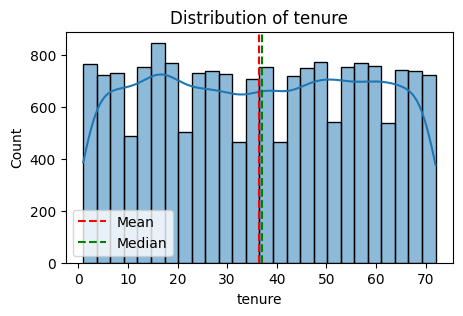

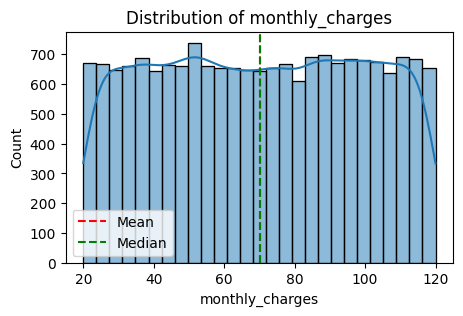

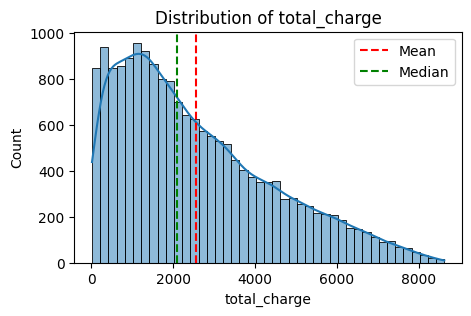

In [71]:
plot_histogram(data,"tenure")

plot_histogram(data,"monthly_charges")

plot_histogram(data,"total_charge")


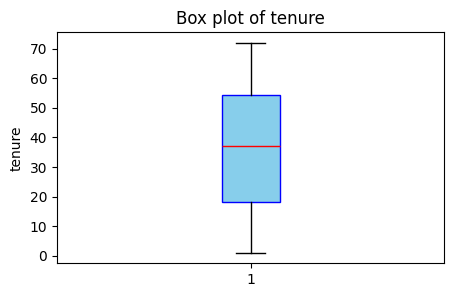

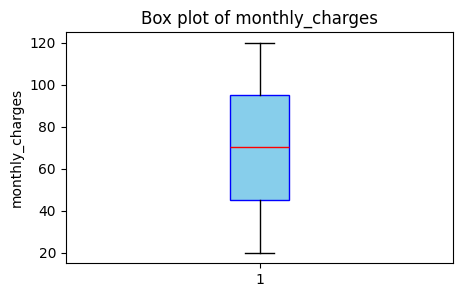

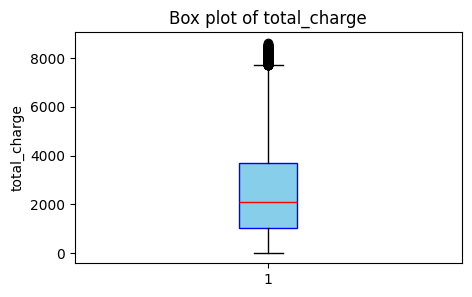

In [72]:
# BOX PLOT FOR NUMERICAL FEATURES.


def plot_boxplot(data, column_name):
    plt.figure(figsize=(5,3))
    
    plt.boxplot(
        data[column_name],
        patch_artist=True,                 
        boxprops=dict(facecolor='skyblue', color='blue'),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black')
    )
    
    plt.title(f"Box plot of {column_name}")
    plt.ylabel(column_name)
    plt.show()

plot_boxplot(data, "tenure")
plot_boxplot(data, "monthly_charges")
plot_boxplot(data, "total_charge")


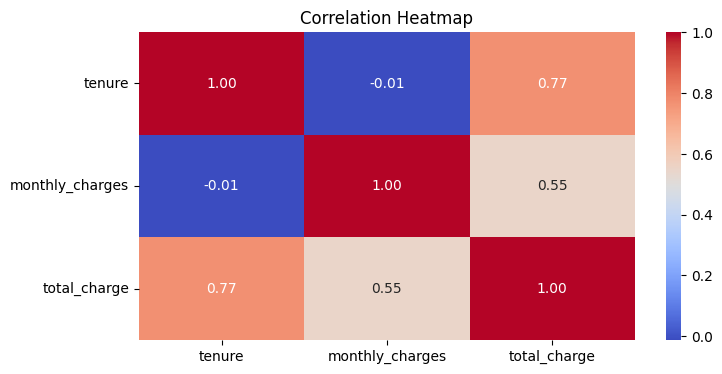

In [73]:
# correlation heatmap for numerical columns 

# correlation matrix - heatmap
plt.figure(figsize=(8,4))
sns.heatmap(data[["tenure","monthly_charges","total_charge"]].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [74]:
# catogoriccal features - Analysis

print(data.columns)

Index(['customer_id', 'tenure', 'monthly_charges', 'total_charge', 'contract',
       'payment_method', 'internet_service', 'tech_support', 'online_security',
       'support_calls', 'churn'],
      dtype='object')


In [75]:
print(data.info)

<bound method DataFrame.info of        customer_id  tenure  monthly_charges  total_charge        contract  \
0                1      52            54.20       2818.40  Month-to-month   
1                2      15            35.28        529.20  Month-to-month   
2                3      72            78.24       5633.28  Month-to-month   
3                4      61            80.24       4894.64        One year   
4                5      21            39.38        826.98  Month-to-month   
...            ...     ...              ...           ...             ...   
19995        19996      36            69.51       2502.36        Two year   
19996        19997      10            59.88        598.80  Month-to-month   
19997        19998       6            42.96        257.76  Month-to-month   
19998        19999       7           102.85        719.95  Month-to-month   
19999        20000      31            44.84       1390.04        Two year   

      payment_method internet_service tech_

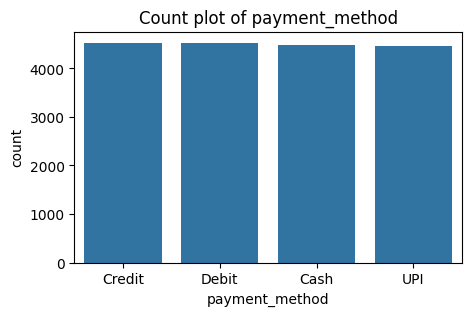

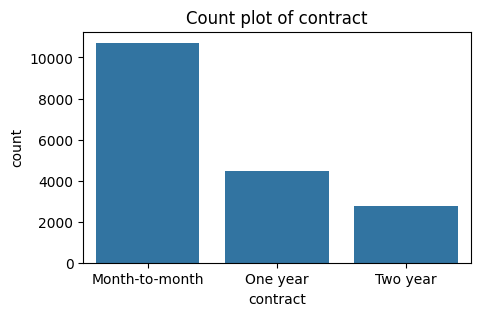

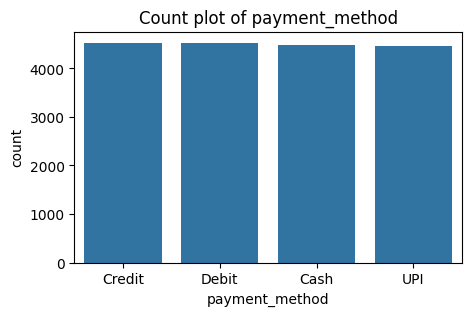

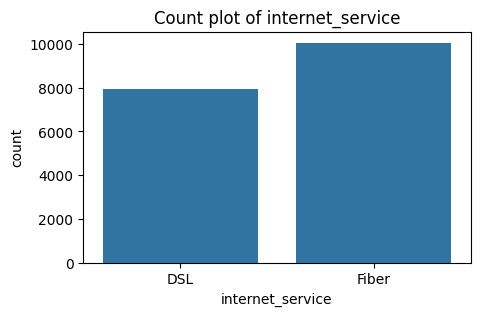

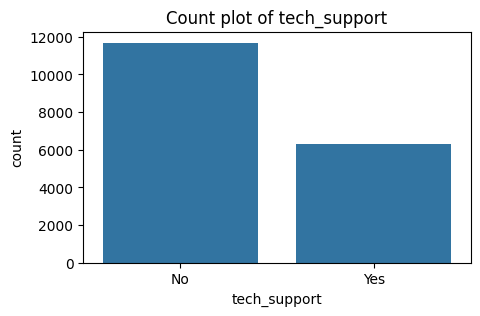

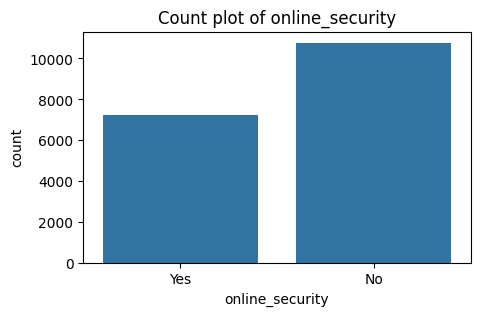

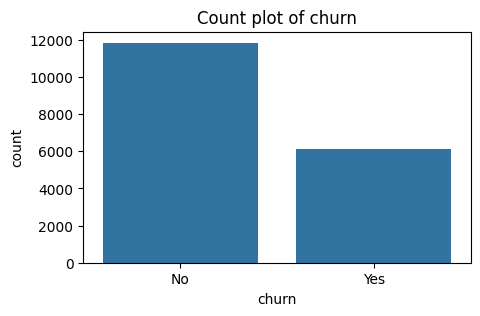

In [76]:
object_cols = data.select_dtypes(include=["object"]).columns.to_list()

object_cols = ["payment_method"] + object_cols

for col in object_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(data=data,x=col)
    plt.title(f"Count plot of {col}")
    plt.show()

4. Data preproccessing.

In [77]:
print(data.head(3))

   customer_id  tenure  monthly_charges  total_charge        contract  \
0            1      52            54.20       2818.40  Month-to-month   
1            2      15            35.28        529.20  Month-to-month   
2            3      72            78.24       5633.28  Month-to-month   

  payment_method internet_service tech_support online_security  support_calls  \
0         Credit              DSL           No             Yes              1   
1          Debit              DSL           No              No              2   
2          Debit              DSL           No              No              0   

  churn  
0    No  
1    No  
2    No  


Label encoding of target column.

In [78]:
data["churn"] = data["churn"].replace({"Yes": 1, "No": 0})
print(data["churn"].value_counts())

churn
0    11853
1     6134
Name: count, dtype: int64


C:\Users\siddh\AppData\Local\Temp\ipykernel_10572\2354728440.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["churn"] = data["churn"].replace({"Yes": 1, "No": 0})


In [79]:
data.head(3)

,customer_id,tenure,monthly_charges,total_charge,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,1,52,54.20,2818.40,Month-to-month,Credit,DSL,No,Yes,1,0
1,2,15,35.28,529.20,Month-to-month,Debit,DSL,No,No,2,0
2,3,72,78.24,5633.28,Month-to-month,Debit,DSL,No,No,0,0


In [80]:
print(data["churn"].value_counts())

churn
0    11853
1     6134
Name: count, dtype: int64


In [81]:
# object (categorical) columns nikaalo
object_columns = data.select_dtypes(include='object').columns
print(data.dtypes)



customer_id           int64
tenure                int64
monthly_charges     float64
total_charge        float64
contract             object
payment_method       object
internet_service     object
tech_support         object
online_security      object
support_calls         int64
churn                 int64
dtype: object


Label encoding of categorical fetaures.

In [82]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

data = pd.read_csv("customer_churn_dataset.csv")
data = data.dropna()

# Get all categorical columns (excluding target if already encoded)
categorical_cols = data.select_dtypes(include='object').columns.tolist()

encoders = {}

for column in categorical_cols:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])
    encoders[column] = label_encoder

# Save the encoders
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [83]:
print(data.head())

   customer_id  tenure  monthly_charges  total_charge  contract  \
0            1      52            54.20       2818.40         0   
1            2      15            35.28        529.20         0   
2            3      72            78.24       5633.28         0   
3            4      61            80.24       4894.64         1   
4            5      21            39.38        826.98         0   

   payment_method  internet_service  tech_support  online_security  \
0               1                 0             0                1   
1               2                 0             0                0   
2               2                 0             0                0   
3               0                 1             1                1   
4               3                 1             0                0   

   support_calls  churn  
0              1      0  
1              2      0  
2              0      0  
3              0      0  
4              4      1  


"Traning and test data split"

In [84]:
# split the data into features and target variable
x = data.drop("churn", axis=1)
y = data["churn"]

print(x)

       customer_id  tenure  monthly_charges  total_charge  contract  \
0                1      52            54.20       2818.40         0   
1                2      15            35.28        529.20         0   
2                3      72            78.24       5633.28         0   
3                4      61            80.24       4894.64         1   
4                5      21            39.38        826.98         0   
...            ...     ...              ...           ...       ...   
19995        19996      36            69.51       2502.36         2   
19996        19997      10            59.88        598.80         0   
19997        19998       6            42.96        257.76         0   
19998        19999       7           102.85        719.95         0   
19999        20000      31            44.84       1390.04         2   

       payment_method  internet_service  tech_support  online_security  \
0                   1                 0             0                1   

In [85]:
print(y)

0        0
1        0
2        0
3        0
4        1
        ..
19995    1
19996    0
19997    0
19998    0
19999    1
Name: churn, Length: 17987, dtype: int64


In [86]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(y_train.shape)


(14389,)


In [87]:
print(y_train.value_counts())

churn
0    9488
1    4901
Name: count, dtype: int64


Synthetic Minority Oversampling TEchnique(SMOTE)

In [88]:
SMOTE = SMOTE(random_state=42)



In [89]:
X_train_smote, y_train_smote = SMOTE.fit_resample(x_train, y_train)

print(y_train_smote.value_counts())

print(X_train_smote.shape)

churn
0    9488
1    9488
Name: count, dtype: int64
(18976, 10)


 " Model Training " 

 Training with default hyperparameters . 

In [90]:
# dictionary to store models and their names

models ={
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

In [91]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model

for model_name, model in models.items():
    print(f"Training {model_name} with default parameters...")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    cv_scores[model_name] = scores
    print(f"{model_name} CV Accuracy: {np.mean(scores):.2f}")
    print("--"*70)

Training Decision Tree with default parameters...
Decision Tree CV Accuracy: 0.72
--------------------------------------------------------------------------------------------------------------------------------------------
Training Random Forest with default parameters...
Random Forest CV Accuracy: 0.81
--------------------------------------------------------------------------------------------------------------------------------------------


In [92]:
cv_scores

{'Decision Tree': array([0.70021075, 0.70355731, 0.71198946, 0.75520422, 0.74888011]),
 'Random Forest': array([0.78424658, 0.78418972, 0.81607378, 0.83662714, 0.83689065])}

Random forest gives the highest accuracy compared to other models with default parameters.

In [93]:
rfc = RandomForestClassifier(random_state=42)

In [94]:
model.fit(X_train_smote, y_train_smote)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [95]:
print(y_test.value_counts())

churn
0    2365
1    1233
Name: count, dtype: int64


" Model Evaluation"

" Load the saved model and build a predictive system.


In [96]:

# =====================================================
# 2. LOAD DATA
# =====================================================
data = pd.read_csv("customer_churn_dataset.csv")

TARGET = "churn"

# =====================================================
# 3. SEPARATE FEATURES & TARGET
# =====================================================
X = data.drop(columns=[TARGET])
y = data[TARGET]

# Remove customer_id if present
if "customer_id" in X.columns:
    X = X.drop(columns=["customer_id"])


# =====================================================
# 4. ENCODE CATEGORICAL COLUMNS 
# =====================================================
label_encoders = {}

for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# save encoders (optional but professional)
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("Categorical columns encoded")


# =====================================================
# 5. TRAIN-TEST SPLIT
# =====================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

from imblearn.over_sampling import SMOTE



# =====================================================
# 6. APPLY SMOTE (NOW IT WILL WORK)
# =====================================================
# APPLY SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTE applied successfully")
print(y_train_smote.value_counts())



# =====================================================
# 7. TRAIN MODEL
# =====================================================
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train_smote, y_train_smote)

print("Model fitted:", hasattr(model, "estimators_"))  # MUST be TRUE


# =====================================================
# 8. SAVE MODEL & FEATURE NAMES
# =====================================================
with open("customer_churn_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("feature_names.pkl", "wb") as f:
    pickle.dump(list(X.columns), f)

print("Model & feature names saved")


# =====================================================
# 9. LOAD MODEL (CONFIRMATION)
# =====================================================
with open("customer_churn_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Loaded model fitted:", hasattr(loaded_model, "estimators_"))


# =====================================================
# 10. NEW CUSTOMER INPUT (ALREADY ENCODED)
# =====================================================
input_data = pd.DataFrame({
    "tenure": [52],
    "monthly_charges": [35.28],
    "total_charge": [529.2],
    "contract": [0],
    "payment_method": [2],
    "internet_service": [0],
    "tech_support": [0],
    "online_security": [1],
    "support_calls": [1]
})

# Match training feature order
with open("feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

input_data = input_data[feature_names]


# =====================================================
# 11. PREDICTION
# =====================================================
prediction = loaded_model.predict(input_data)
probability = loaded_model.predict_proba(input_data)

print("\n===============================")
print(" CUSTOMER CHURN PREDICTION ")
print("===============================")

if prediction[0] == 1:
    print("Result: CUSTOMER WILL CHURN ❌")
else:
    print("Result: CUSTOMER WILL STAY ✅")

print("Prediction Probability:", probability)


Categorical columns encoded
SMOTE applied successfully
churn
No     10526
Yes    10526
Name: count, dtype: int64
Model fitted: True
Model & feature names saved
Loaded model fitted: True

 CUSTOMER CHURN PREDICTION 
Result: CUSTOMER WILL STAY ✅
Prediction Probability: [[0.62 0.38]]


"Model predicts that the customer is likely to stay with a probability of 62%. Since the probability of non-churn is higher than churn, the final prediction is customer will stay.”

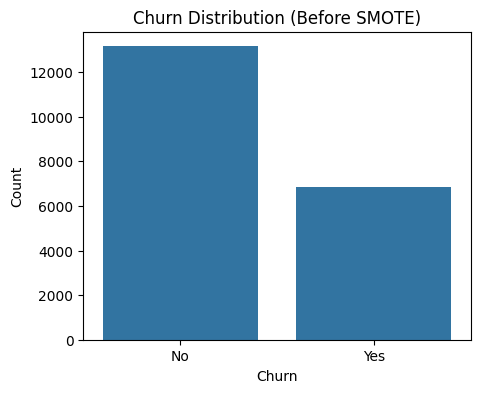

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Churn Distribution (Before SMOTE)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


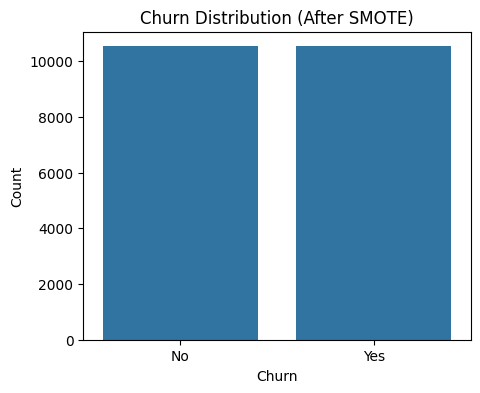

In [98]:
plt.figure(figsize=(5,4))
sns.countplot(x=y_train_smote)
plt.title("Churn Distribution (After SMOTE)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


“SMOTE balanced the dataset successfully”

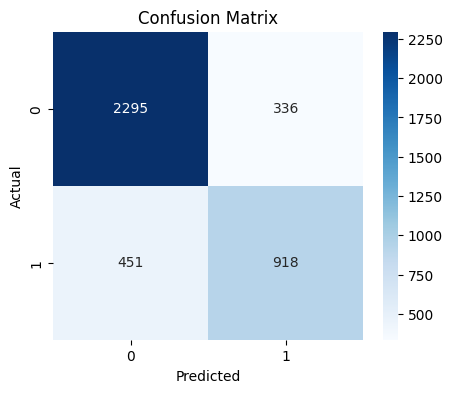

In [99]:
from sklearn.metrics import confusion_matrix

y_pred = loaded_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


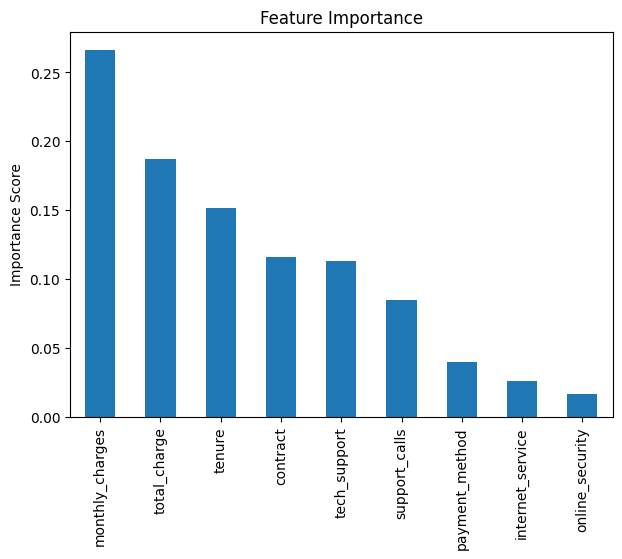

In [100]:
import pandas as pd

feature_importance = pd.Series(
    loaded_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(7,5))
feature_importance.plot(kind="bar")
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.show()


“I visualized churn distribution before and after SMOTE,
evaluated model performance using confusion matrix and
ROC curve, and analyzed feature importance to understand
key churn drivers.”